# Figure 2

Presented at the start of the results, this contains a schematic for the DRL as well as a comparison of different therapy methods

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../utils")
from myUtils import convert_ode_parameters, TreatmentListToTS, ExtractTreatmentFromDf
from LotkaVolterraModel import LotkaVolterraModel

In [2]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Daily':(0.8305040136860113, 0.7185155941571258, 1.0)}
# Daily colour is a lighted version of the monthly color calculated in Figure 2

## Panel A - DRL Schematic

In [3]:
def PlotDrug(dataDf, ax, color, plotDrugAsBar=True, currDrugBarPosition = 1.2, drugBarHeight = 0.2, line_max=None, **kwargs):
    # Generate drug data as time series from list
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    # Plot as bars across top of plot. Cleaner, but can be harder to see alignment with tumour trajectory.
    # Rescale to make it fit within the bar at the top of the plot
    drugConcentrationVec = drugConcentrationVec * drugBarHeight + currDrugBarPosition
    line_max = dataDf['Time'].max() if line_max is None else line_max
    ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                     alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition, linewidth=3, color="black")
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")


def Plot(df, legend=False, drug_label="Drug Concentration",
         ax=None, linewidth=5, drug_limit = None, **kwargs):
    if ax is None: fig, ax = plt.subplots(1, 1)
    currModelPredictionDf = pd.melt(df, id_vars=['Time'], value_vars=["TumourSize"])
    ax.plot(currModelPredictionDf['Time'], currModelPredictionDf['value'], linewidth=linewidth, **kwargs)

    PlotDrug(df, ax, 'k', plotDrugAsBar = True, currDrugBarPosition = 0.12, drugBarHeight = 0.02, line_max=drug_limit)

    # Format the plot
    ax.set_title(kwargs.get('title', ''))
    # plt.tight_layout()

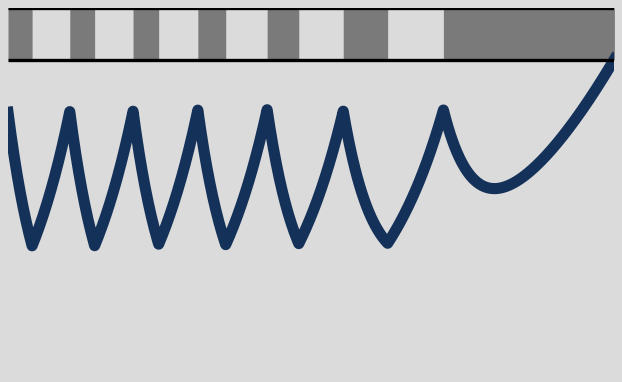

In [4]:
n0, r0 = 0.1, 0.003
cost, turnover = 0.4, 0.4
rs = 0.027  # From literature
t_max = 4000

fig, ax = plt.subplots(1, 1, figsize = (8,5))


model = LotkaVolterraModel(method='RK45', dt = 1)
paramDic = {"Cost": cost, "Turnover": turnover,
            "N0": n0, "R0": r0, "S0": (n0 - r0),
            "rS": rs, "rR": rs * (1-cost),
            "dS": rs * turnover, "dR": rs * turnover,
            'K': 1.5, 'DD': 1.5}
model.SetParams(**paramDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=t_max)

Plot(model.resultsDf, ax=ax, legend=False, color = colors['AT'], linewidth=10)
ax.set_xlim(0, model.ttp); ax.set_ylim(0, 0.14); ax.axis('off')
ax.tick_params(top=False, right=False, bottom=False, left=False)

ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.savefig("figures/fig1a_good_example_at.pdf")

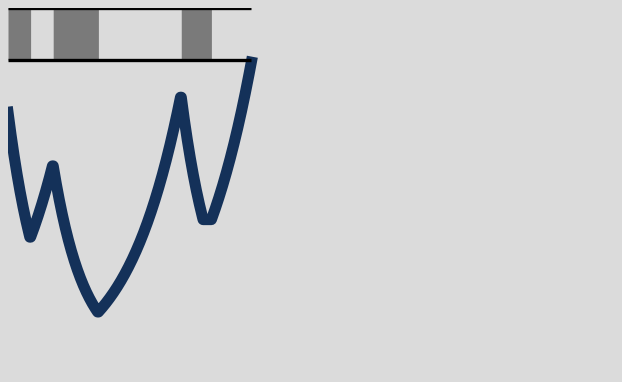

In [5]:
# Example of the model, with a poorly chosen drug schedule

poor_model = LotkaVolterraModel(method='RK45', dt = 1)
poor_model.SetParams(**paramDic)
poor_model.Simulate(treatmentScheduleList=[[0, 30, 1], [30, 60, 0], [60, 120, 1], [120, 230, 0], [230, 260, 1], [270, 900, 0]])
poor_model.resultsDf = poor_model.resultsDf[poor_model.resultsDf['TumourSize'] < 1.2 * n0]

fig, ax = plt.subplots(1, 1, figsize = (8,5))
Plot(poor_model.resultsDf, ax=ax, legend=False, color = colors['AT'], linewidth=10, drug_limit=max(poor_model.resultsDf['Time']))
ax.set_xlim(0, model.ttp); ax.set_ylim(0, 0.14), ax.axis('off')
ax.tick_params(top=False, right=False, bottom=False, left=False)

ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.savefig("figures/fig1a_poor_example_at.pdf")

## Panel B - Treatment Comparison

In [6]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(os.pardir, file_path, "models")
results_path = os.path.join(file_path, "data", "Fig2")
runFromScratch = True

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)

In [7]:
def Plot_method(df, legend=False, drug_label="Drug Concentration",
         ax=None, linewidth=5, drug_limit = None, colors = None, **kwargs):
    if ax is None: fig, ax = plt.subplots(1, 1)
    linestyles = ['-', '--', '--']
    for i, var in enumerate(["TumourSize", 'S', 'R']):
        ax.plot(df['Time'], df[var], linewidth=linewidth, linestyle=linestyles[i], color=colors[var], **kwargs)

    PlotDrug(df, ax, 'k', plotDrugAsBar = True, line_max=drug_limit, currDrugBarPosition = 1.25)
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1, linestyles=":", linewidth=6, color='grey')
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1.2, linestyles=":", linewidth=6, color='grey')

    # Format the plot
    ax.set_title(kwargs.get('title', ''))
    ax.set_xlim(0, x_lim); ax.set_ylim(0, 1.4)
    ax.yaxis.get_major_ticks()[-1].set_visible(False); ax.tick_params(right = False, top = False)
    plt.tight_layout()

In [10]:
# Compute performance under rule of thumb
at_model = LotkaVolterraModel(method='RK45')
at_model.SetParams(**odeParamDic)
at_model.Simulate_AT(atThreshold=0.5, intervalLength=updating_interval, t_end=5000);
at_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at_model.Trim(dt=1)

# Compute performance under continuous therapy
ct_model = LotkaVolterraModel(method='RK45')
ct_model.SetParams(**odeParamDic)
ct_model.Simulate([[0, 2000, 1]])
ct_model.Trim(dt=1)
ct_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0']
ct_model.resultsDf = ct_model.resultsDf[ct_model.resultsDf['TumourSize'] < ct_model.resultsDf['TumourSize'][0] * 1.2]
ct_model.ttp = max(ct_model.resultsDf['Time'])

In [9]:
plt.rcParams['font.size'] = '18'
updating_interval = 1; model_name = 'ThuMar311244502022'; n_epochs = 2600
results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
    currDataDf[col] /= odeParamDic['n0']
drl_df = currDataDf[currDataDf.ReplicateId == 2]
x_lim = max(drl_df['Time'])
print(x_lim)


800


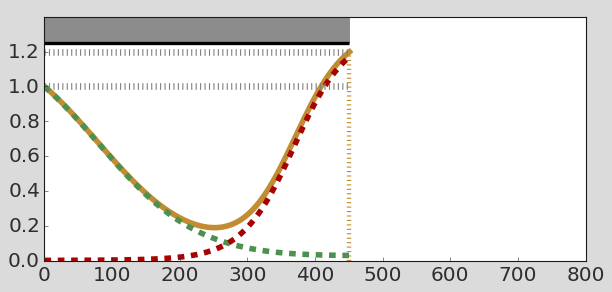

In [11]:
fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {'TumourSize': colors['CT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(ct_model.resultsDf, ax=ax, legend=False, colors = palette)
ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)


plt.savefig("figures/fig1b_CT.pdf")

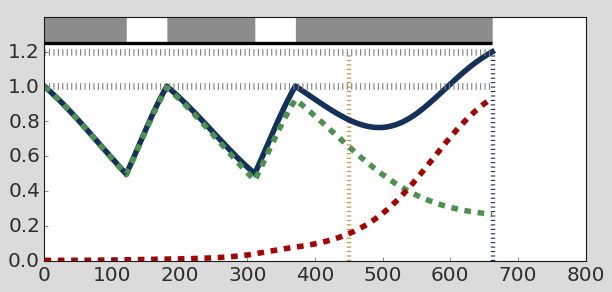

In [12]:
fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {'TumourSize': colors['AT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(at_model.resultsDf, ax=ax, legend=False, colors = palette)
ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)
ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)

ax.set_xlim(0, x_lim); ax.set_ylim(0, 1.4)
plt.savefig("figures/fig1b_AT.pdf")

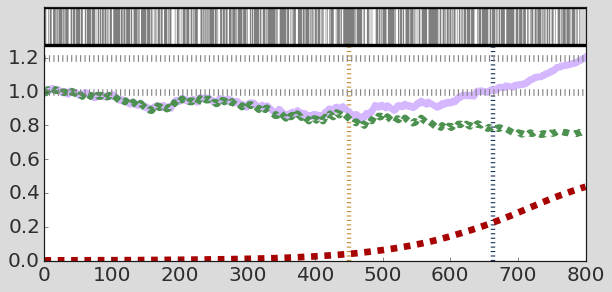

In [13]:
fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {"TumourSize": colors["DRL_Daily"], "S": colors["Sensitive"], "R": colors["Resistant"]}
plot_simulation(currDataDf[currDataDf.ReplicateId == 2], plotPops=True, lineplot_kws={'estimator':None, 'units':"ReplicateId", 'lw': 6, 'palette': palette},
                decorateAxes=False, decoratey2=False ,markInitialSize=True, markProgression=True, ylim=[0,1.5], xlim=[0, x_lim], ax=ax)

ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)


ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.tick_params(right = False, top = False)
plt.savefig("figures/fig1b_DRL.pdf")

In [14]:
print(currDataDf[currDataDf.ReplicateId == 2].tail())

      Unnamed: 0 Action  DrugConcentration  PatientId         R  ReplicateId  \
2570        2570      H                0.0          0  0.432282            2   
2571        2571      H                0.0          0  0.433497            2   
2572        2572      T                1.0          0  0.434686            2   
2573        2573      H                0.0          0  0.435863            2   
2574        2574      H                0.0          0  0.437028            2   

             S  Support_Hol  Support_Treat  Time  TumourSize  
2570  0.760802     0.361063       0.638937   796    1.193084  
2571  0.762940     0.361474       0.638526   797    1.196437  
2572  0.765033     0.361870       0.638130   798    1.199718  
2573  0.763999     0.361889       0.638111   799    1.199862  
2574  0.766042     0.361889       0.638111   800    1.203070  


## Display variation in these results for the appendix

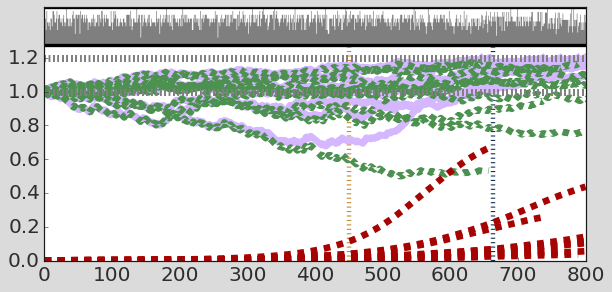

In [19]:
fix, ax = plt.subplots(1,1,figsize=(8,4))

plot_simulation(currDataDf[currDataDf.ReplicateId < 10], plotPops=True, lineplot_kws={'estimator':None, 'units':"ReplicateId", 'lw': 6, 'palette': palette},
                decorateAxes=False, decoratey2=False ,markInitialSize=True, markProgression=True, ylim=[0,1.5], xlim=[0, x_lim], ax=ax)

ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)


ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.tick_params(right = False, top = False)
# plt.savefig("figures/figSI_DRL_variation.pdf")

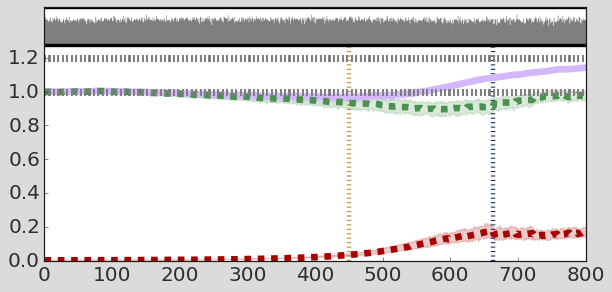

In [16]:
# plot_simulation(currDataDf, plotPops=True, lineplot_kws={'n_boot':100},
#                 markInitialSize=True, markProgression=True)#, ylim=[0,0.2])

fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {"TumourSize": colors["DRL_Daily"], "S": colors["Sensitive"], "R": colors["Resistant"]}
plot_simulation(currDataDf, plotPops=True, lineplot_kws={'lw': 6, 'palette': palette, 'n_boot':100},
                decorateAxes=False, decoratey2=False ,markInitialSize=True, markProgression=True, ylim=[0,1.5], xlim=[0, x_lim], ax=ax)

ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["AT"], zorder=0)
ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 4, color=colors["CT"], zorder=0)


ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.tick_params(right = False, top = False)
# plt.savefig("figures/figSI_DRL_variation.pdf")

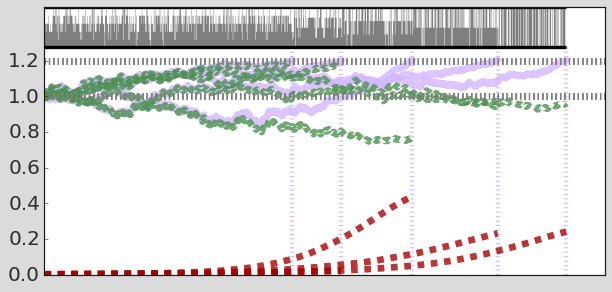

In [22]:
# for i in currDataDf.ReplicateId.unique():
#     print(f"{i}: {max(currDataDf[currDataDf.ReplicateId == i].Time)}")

sample_list = [2, 4, 15, 26, 66]
ttp_vals = [max(currDataDf[currDataDf.ReplicateId == i].Time) for i in sample_list]

fix, ax = plt.subplots(1,1,figsize=(8,4))
palette = {"TumourSize": colors["DRL_Daily"], "S": colors["Sensitive"], "R": colors["Resistant"]}
plot_simulation(currDataDf[currDataDf.ReplicateId.isin(sample_list)], plotPops=True, lineplot_kws={'estimator':None, 'units':"ReplicateId", 'lw': 6, 'palette': palette, 'n_boot':100, 'alpha': 0.8},
                decorateAxes=False, decoratey2=False ,markInitialSize=True, markProgression=True, ylim=[0,1.5], xlim=[0, 1220], ax=ax)

for val in ttp_vals:
    ax.axvline(val, 0, 0.85, linestyle=':', linewidth = 4, color=colors["DRL_Daily"], zorder=0)
    
# ax.axvline(at_model.ttp, 0, 0.85, linestyle=':', linewidth = 6, color=colors["AT"], zorder=0)
# ax.axvline(ct_model.ttp, 0, 0.85, linestyle=':', linewidth = 6, color=colors["CT"], zorder=0)


ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.tick_params(right = False, top = False)
ax.get_xaxis().set_ticks([])  # When combined in multipanel figure with the histogram below
plt.tight_layout(); plt.savefig("figures/figSI_DRL_variation.pdf")

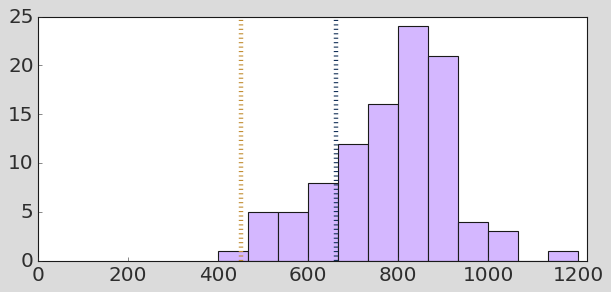

In [18]:
ttp_df = currDataDf.drop_duplicates(subset = ['ReplicateId'], keep='last')

fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(ttp_df.Time, bins=12, range = (400, 1200), color = colors["DRL_Daily"])

ax.axvline(at_model.ttp, 0, ax.get_ylim()[1], linestyle=':', linewidth = 4, color=colors["AT"], zorder=2)
ax.axvline(ct_model.ttp, 0, ax.get_ylim()[1], linestyle=':', linewidth = 4, color=colors["CT"], zorder=2)
# ax.axvline(ttp_df.Time.mean(), 0, ax.get_ylim()[1], linestyle=':', linewidth = 4, color=colors["DRL_Daily"], zorder=2)

plt.xticks(np.arange(0, 1400, 200)); ax.set_xlim([0, 1220]) #350, 1250)
ax.tick_params(right = False, top = False); plt.tight_layout()
plt.savefig("figures/figSI_DRL_hist.pdf")                                                            